# Upload data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = '/content/drive/MyDrive/AI/data_6'
data = ['test', 'train', 'train_cleaned']
batch_size = 64

#Pre processing

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transform
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np 
import math
from PIL import Image
import glob

import shutil
import os

from torchvision import datasets
from torchvision.utils import save_image

In [ ]:
out_0 = os.listdir(path + '/' + data[0])
out_0.sort()
out_1 = os.listdir(path + '/' + data[1])
out_1.sort()
out_2 = os.listdir(path + '/' + data[2])
out_2.sort()

print(out_0)
print(out_1)
print(out_2)

['1.png', '10.png', '100.png', '103.png', '106.png', '109.png', '112.png', '115.png', '118.png', '121.png', '124.png', '127.png', '13.png', '130.png', '133.png', '136.png', '139.png', '142.png', '145.png', '148.png', '151.png', '154.png', '157.png', '16.png', '160.png', '163.png', '166.png', '169.png', '172.png', '175.png', '178.png', '181.png', '184.png', '187.png', '19.png', '190.png', '193.png', '196.png', '199.png', '202.png', '205.png', '208.png', '211.png', '214.png', '22.png', '25.png', '28.png', '31.png', '34.png', '37.png', '4.png', '40.png', '43.png', '46.png', '49.png', '52.png', '55.png', '58.png', '61.png', '64.png', '67.png', '7.png', '70.png', '73.png', '76.png', '79.png', '82.png', '85.png', '88.png', '91.png', '94.png', '97.png']
['101.png', '102.png', '104.png', '105.png', '107.png', '108.png', '11.png', '110.png', '111.png', '113.png', '114.png', '116.png', '117.png', '119.png', '12.png', '120.png', '122.png', '123.png', '125.png', '126.png', '128.png', '129.png', '1

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [ ]:
standar_size = (540,258)
import torchvision.transforms.functional as TF
from PIL import Image

test_set = []
for i in out_0:
  a = Image.open(path + '/' + data[0] + '/' + i)
  a = a.resize(standar_size)
  x = TF.to_tensor(a)
  x.unsqueeze_(0)
  test_set.append(x)

train_set = []
for i in out_1:
  a = Image.open(path + '/' + data[1] + '/' + i)
  a = a.resize(standar_size)
  x = TF.to_tensor(a)
  x.unsqueeze_(0)
  train_set.append(x)

train_cleaned_set = []
for i in out_2:
  a = Image.open(path + '/' + data[2] + '/' + i)
  a = a.resize(standar_size)
  x = TF.to_tensor(a)
  x.unsqueeze_(0)
  train_cleaned_set.append(x)

In [ ]:
#Loaders
train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=batch_size, shuffle=False)
train_clean_loader = torch.utils.data.DataLoader(dataset=train_cleaned_set, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=batch_size, shuffle=True)


#Autoencoder CNN

In [ ]:
pool = nn.MaxPool2d(2, stride=2, return_indices=True)
unpool = nn.MaxUnpool2d(2, stride=2)

class Encoder(nn.Module):
  def __init__(self):
    super(Encoder,self).__init__()
    self.f1 = nn.Sequential(
        nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU()
    )
    self.f2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU()
    )
    self.f3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU()
    )
    self.f4 = nn.Sequential(
            nn.Linear(135, 12)
    )

  def forward(self, image):
    out = self.f1(image)
    out, indices1 = pool(out)
    out = self.f2(out)
    out, indices2 = pool(out)
    z = self.f3(out)
    z = self.f4(z)
    return z, indices1,  indices2

class Decoder(nn.Module):
  def __init__(self):
    super(Decoder,self).__init__()

    self.f0 = nn.Sequential(
            nn.Linear(12, 135)
    )

    self.f1 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU()
    )
    self.f2 = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=(4,3), stride=1, padding=1),
            nn.ReLU()
    )
    self.f3 = nn.Sequential(
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=1, padding=1),
            nn.ReLU()
    )

  def forward(self, z):
    z, indices1, indices2 = z
    z = self.f0(z)
    out = self.f1(z)
    out = unpool(out, indices2)
    out = self.f2(out)
    out = unpool(out, indices1)
    out = torch.tanh(self.f3(out))
    return out

class Process(nn.Module):
  def __init__(self):
    super(Process,self).__init__()
    self.f1 = nn.Sequential(
        nn.Conv2d(1, 3, kernel_size=3, stride=1, padding=1),
            nn.ReLU()
    )
    self.f2 = nn.Sequential(
            nn.Conv2d(3, 5, kernel_size=3, stride=1, padding=1),
            nn.ReLU()
    )
    self.f3 = nn.Sequential(
            nn.Conv2d(5, 3, kernel_size=3, stride=1, padding=1),
            nn.ReLU()
    )
    self.f4 = nn.Sequential(
            nn.Conv2d(3, 1, kernel_size=3, stride=1, padding=1)
    )

  def forward(self, image):
    out = self.f1(image)
    out = self.f2(out)
    out = self.f3(out)
    z = torch.tanh(self.f4(out))
    return z

class Autoncoder(nn.Module):
  def __init__(self):
    super(Autoncoder,self).__init__()
    self.encoder = Encoder()
    self.Decoder = Decoder()
    self.Process = Process()
  def forward(self, image):
    z = self.encoder(image)
    out = self.Decoder(z)
    out = self.Process(out)
    return out
  def reiniciar(self):
    super(Autoncoder,self).__init__()
    self.encoder = Encoder()
    self.Decoder = Decoder()
    self.Process = Process()


#Functions

In [ ]:

def img_autoencoder(model, path_i):
  autoencoder = model.to(device)
  a = Image.open(path_i)
  a = a.resize(standar_size)
  a = a.convert('L')
  img = TF.to_tensor(a)
  img.unsqueeze_(0)
  img = img.to(device)
  Show_Weight(img)
  img_recon = autoencoder(img)
  img_recon = img_recon.to(device)
  Show_Weight(img_recon)
  return img_recon

## Show image

In [ ]:
def read_img(path_i):
  a = Image.open(path_i)
  a = a.resize(standar_size)
  a = a.convert('L')
  x = TF.to_tensor(a)
  x.unsqueeze_(0)
  return x

In [ ]:
def Show(out, title = ''):
  print(title)
  out = out.permute(1,0,2,3)
  grilla = torchvision.utils.make_grid(out,10,5)
  plt.imshow(transforms.ToPILImage()(grilla), 'jet')
  plt.show()

def Show_Weight(out):
  grilla = torchvision.utils.make_grid(out)
  plt.imshow(transform.ToPILImage()(grilla), 'jet')
  plt.show()

##Train

In [ ]:
from sklearn.utils import shuffle

def train(model, train_s, train_cleaned_s, Epochs, loss_fn):
    train_loss_avg = []
    for epoch in range(Epochs):
      train_loss_avg.append(0)
      num_batches = 0
      
      #for img in train_s:
      train_s, train_cleaned_s = shuffle(train_s, train_cleaned_s)
      for i in range(batch_size):
          img = train_s[i]
          #img = img.view(img.size(0),-1)
          img = img.to(device)
          img_recon = model(img)
          #img_clean = train_cleaned_s[i].view(train_cleaned_s[i].size(0),-1).to(device)
          img_clean = train_cleaned_s[i].to(device)
          loss = loss_fn(img_recon, img_clean)
          
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          
          train_loss_avg[-1] += loss.item()
          num_batches += 1
      
      train_loss_avg[-1] /= num_batches
      print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, Epochs, train_loss_avg[-1]))
      if loss < 0.005:
        break    
    return train_loss_avg

## K-fold

In [ ]:
def Kfold_t(model, train_s, train_cleaned_s, Epochs, loss_fn, optimizer, fold=10):
  kfold = KFold(n_splits=fold, shuffle=False)
  loss_array = []
  for fold, (train_ids, test_ids) in enumerate(kfold.split(range(len(train_s)))):
    model.reiniciar()
    model.to(device)
    optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate, weight_decay=1e-5)

    num_batches_train = 0
    train_loss_avg = []
    for epoch in range(Epochs):
      train_loss_avg.append(0)
      for i in train_ids:
        img = train_s[i]
        img = img.to(device)
        img_recon = model(img)
        img_clean = train_cleaned_s[i].to(device)
        loss = loss_fn(img_recon, img_clean)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss_avg[-1] += loss.item()
        num_batches_train += 1
      train_loss_avg[-1] /= num_batches_train
      print('Fold: ', fold, 'Epoch: [',epoch+1, '/',Epochs,'] Loss:', train_loss_avg[-1])
    
    img_test = model(test_set[0].to(device))
    Show_Weight(img_test)

    test_loss_avg = []
    test_loss_avg.append(0)
    num_batches = 0
    for i in test_ids:
      img = train_s[i]
      img = img.to(device)
      img_recon = model(img)
      img_clean = train_cleaned_s[i].to(device)
      loss = loss_fn(img_recon, img_clean)
      test_loss_avg[-1] += loss.item()
      num_batches += 1
      print('Test: [',i+1, '/',len(test_ids),'] Loss:', loss.item())
    # if loss < 0.005:
    #   break
    test_loss_avg[-1] /= num_batches
    loss_array.append(test_loss_avg[-1])
    print('         Fold: ', fold, 'Test avg Loss:', loss_array[-1])
    print(len(test_loss_avg))
  return loss_array

Notes:
* All the train set contains the same text and all the test set contains the same text too, but is different from train set
* The loss should be at leas 0.025 to archive aceptable results.
* The loss can get stuck between 0.06 and 0.05 which implies that the image is all white or mostly white without defined letters.
* If the loss get stuck between 0.06 and 0.05, it is mostly likely that the learning rate is incorrect
* A simple CNN can archive good results but as our goal is to reduce dimentionality we use a CNN autoencoder  

#Experimentation

Fold:  0 Epoch: [ 1 / 40 ] Loss: 0.9982730839563453
Fold:  0 Epoch: [ 2 / 40 ] Loss: 0.30970504828121354
Fold:  0 Epoch: [ 3 / 40 ] Loss: 0.055728581288586494
Fold:  0 Epoch: [ 4 / 40 ] Loss: 0.019633189928920373
Fold:  0 Epoch: [ 5 / 40 ] Loss: 0.013923310054385143
Fold:  0 Epoch: [ 6 / 40 ] Loss: 0.011317573898080467
Fold:  0 Epoch: [ 7 / 40 ] Loss: 0.009626186842688863
Fold:  0 Epoch: [ 8 / 40 ] Loss: 0.007802006784502579
Fold:  0 Epoch: [ 9 / 40 ] Loss: 0.005548162711559286
Fold:  0 Epoch: [ 10 / 40 ] Loss: 0.00433773323893547
Fold:  0 Epoch: [ 11 / 40 ] Loss: 0.003625248154632659
Fold:  0 Epoch: [ 12 / 40 ] Loss: 0.002977503728175509
Fold:  0 Epoch: [ 13 / 40 ] Loss: 0.0024532540586082435
Fold:  0 Epoch: [ 14 / 40 ] Loss: 0.002070491511073912
Fold:  0 Epoch: [ 15 / 40 ] Loss: 0.0017943119030931721
Fold:  0 Epoch: [ 16 / 40 ] Loss: 0.0015742399608311445
Fold:  0 Epoch: [ 17 / 40 ] Loss: 0.0014036293391643277
Fold:  0 Epoch: [ 18 / 40 ] Loss: 0.0012316429254189494
Fold:  0 Epoch: [ 

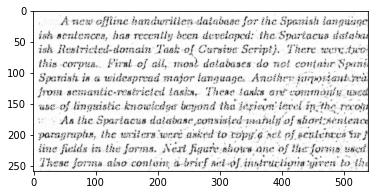

Test: [ 1 / 29 ] Loss: 0.01099900808185339
Test: [ 2 / 29 ] Loss: 0.011226112954318523
Test: [ 3 / 29 ] Loss: 0.012518028728663921
Test: [ 4 / 29 ] Loss: 0.01147428248077631
Test: [ 5 / 29 ] Loss: 0.012064680457115173
Test: [ 6 / 29 ] Loss: 0.012279599905014038
Test: [ 7 / 29 ] Loss: 0.011897656135261059
Test: [ 8 / 29 ] Loss: 0.013291041366755962
Test: [ 9 / 29 ] Loss: 0.013599210418760777
Test: [ 10 / 29 ] Loss: 0.01255941390991211
Test: [ 11 / 29 ] Loss: 0.01309131272137165
Test: [ 12 / 29 ] Loss: 0.013725933618843555
Test: [ 13 / 29 ] Loss: 0.013120816089212894
Test: [ 14 / 29 ] Loss: 0.013865327462553978
Test: [ 15 / 29 ] Loss: 0.011428643949329853
Test: [ 16 / 29 ] Loss: 0.014168805442750454
Test: [ 17 / 29 ] Loss: 0.011931744404137135
Test: [ 18 / 29 ] Loss: 0.012005412951111794
Test: [ 19 / 29 ] Loss: 0.010621939785778522
Test: [ 20 / 29 ] Loss: 0.011197035200893879
Test: [ 21 / 29 ] Loss: 0.012851365841925144
Test: [ 22 / 29 ] Loss: 0.011501781642436981
Test: [ 23 / 29 ] Loss:

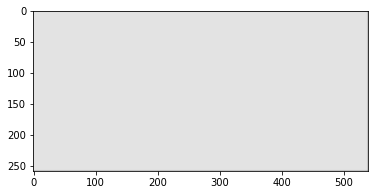

Test: [ 30 / 29 ] Loss: 0.06099475920200348
Test: [ 31 / 29 ] Loss: 0.06297052651643753
Test: [ 32 / 29 ] Loss: 0.06099475920200348
Test: [ 33 / 29 ] Loss: 0.06297052651643753
Test: [ 34 / 29 ] Loss: 0.05477425083518028
Test: [ 35 / 29 ] Loss: 0.055245187133550644
Test: [ 36 / 29 ] Loss: 0.05477425083518028
Test: [ 37 / 29 ] Loss: 0.06015067175030708
Test: [ 38 / 29 ] Loss: 0.055245187133550644
Test: [ 39 / 29 ] Loss: 0.05477425083518028
Test: [ 40 / 29 ] Loss: 0.055245187133550644
Test: [ 41 / 29 ] Loss: 0.05477425083518028
Test: [ 42 / 29 ] Loss: 0.055245187133550644
Test: [ 43 / 29 ] Loss: 0.05431962013244629
Test: [ 44 / 29 ] Loss: 0.05552045628428459
Test: [ 45 / 29 ] Loss: 0.05431962013244629
Test: [ 46 / 29 ] Loss: 0.05552045628428459
Test: [ 47 / 29 ] Loss: 0.05431962013244629
Test: [ 48 / 29 ] Loss: 0.05552045628428459
Test: [ 49 / 29 ] Loss: 0.05431962013244629
Test: [ 50 / 29 ] Loss: 0.05552045628428459
Test: [ 51 / 29 ] Loss: 0.05986132472753525
Test: [ 52 / 29 ] Loss: 0.07

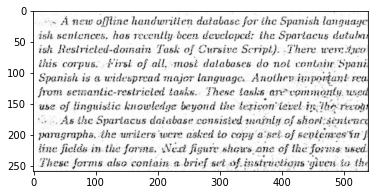

Test: [ 59 / 29 ] Loss: 0.009058577939867973
Test: [ 60 / 29 ] Loss: 0.010317938402295113
Test: [ 61 / 29 ] Loss: 0.011246701702475548
Test: [ 62 / 29 ] Loss: 0.011348876170814037
Test: [ 63 / 29 ] Loss: 0.011347269639372826
Test: [ 64 / 29 ] Loss: 0.011249667033553123
Test: [ 65 / 29 ] Loss: 0.011139131151139736
Test: [ 66 / 29 ] Loss: 0.010967581532895565
Test: [ 67 / 29 ] Loss: 0.01195346936583519
Test: [ 68 / 29 ] Loss: 0.011688566766679287
Test: [ 69 / 29 ] Loss: 0.011254973709583282
Test: [ 70 / 29 ] Loss: 0.011061376892030239
Test: [ 71 / 29 ] Loss: 0.011071154847741127
Test: [ 72 / 29 ] Loss: 0.010696649551391602
Test: [ 73 / 29 ] Loss: 0.009859124198555946
Test: [ 74 / 29 ] Loss: 0.009611203335225582
Test: [ 75 / 29 ] Loss: 0.011047172360122204
Test: [ 76 / 29 ] Loss: 0.010525288991630077
Test: [ 77 / 29 ] Loss: 0.011369607411324978
Test: [ 78 / 29 ] Loss: 0.011033805087208748
Test: [ 79 / 29 ] Loss: 0.011748850345611572
Test: [ 80 / 29 ] Loss: 0.011932296678423882
Test: [ 81 

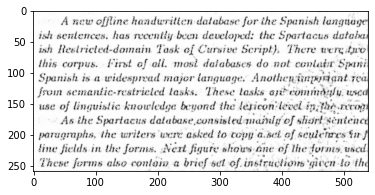

Test: [ 88 / 29 ] Loss: 0.011526898480951786
Test: [ 89 / 29 ] Loss: 0.011185676790773869
Test: [ 90 / 29 ] Loss: 0.013984167017042637
Test: [ 91 / 29 ] Loss: 0.013775159604847431
Test: [ 92 / 29 ] Loss: 0.013375859707593918
Test: [ 93 / 29 ] Loss: 0.011582165956497192
Test: [ 94 / 29 ] Loss: 0.012520639225840569
Test: [ 95 / 29 ] Loss: 0.013646800071001053
Test: [ 96 / 29 ] Loss: 0.012541797012090683
Test: [ 97 / 29 ] Loss: 0.013855588622391224
Test: [ 98 / 29 ] Loss: 0.013047438114881516
Test: [ 99 / 29 ] Loss: 0.01536407321691513
Test: [ 100 / 29 ] Loss: 0.014843960292637348
Test: [ 101 / 29 ] Loss: 0.014833097346127033
Test: [ 102 / 29 ] Loss: 0.013698150403797626
Test: [ 103 / 29 ] Loss: 0.015023462474346161
Test: [ 104 / 29 ] Loss: 0.013539047911763191
Test: [ 105 / 29 ] Loss: 0.015484850853681564
Test: [ 106 / 29 ] Loss: 0.014260555617511272
Test: [ 107 / 29 ] Loss: 0.011015776544809341
Test: [ 108 / 29 ] Loss: 0.014384672977030277
Test: [ 109 / 29 ] Loss: 0.014695368707180023
T

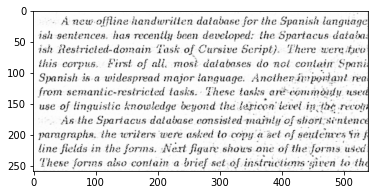

Test: [ 117 / 28 ] Loss: 0.008806414902210236
Test: [ 118 / 28 ] Loss: 0.009485450573265553
Test: [ 119 / 28 ] Loss: 0.00854360032826662
Test: [ 120 / 28 ] Loss: 0.008482558652758598
Test: [ 121 / 28 ] Loss: 0.008726890198886395
Test: [ 122 / 28 ] Loss: 0.00827525183558464
Test: [ 123 / 28 ] Loss: 0.00904137548059225
Test: [ 124 / 28 ] Loss: 0.008911872282624245
Test: [ 125 / 28 ] Loss: 0.0056688920594751835
Test: [ 126 / 28 ] Loss: 0.00608838303014636
Test: [ 127 / 28 ] Loss: 0.005082877352833748
Test: [ 128 / 28 ] Loss: 0.005212866235524416
Test: [ 129 / 28 ] Loss: 0.008209188468754292
Test: [ 130 / 28 ] Loss: 0.00539134768769145
Test: [ 131 / 28 ] Loss: 0.0053383708000183105
Test: [ 132 / 28 ] Loss: 0.005358708556741476
Test: [ 133 / 28 ] Loss: 0.0056187305599451065
Test: [ 134 / 28 ] Loss: 0.006103363819420338
Test: [ 135 / 28 ] Loss: 0.006162987090647221
Test: [ 136 / 28 ] Loss: 0.005696234758943319
Test: [ 137 / 28 ] Loss: 0.007622325327247381
Test: [ 138 / 28 ] Loss: 0.005654435

In [ ]:
from sklearn.model_selection import KFold

learning_rate = 0.0001
autoencoder = Autoncoder()
autoencoder.to(device)
loss = nn.MSELoss()
optimizer = torch.optim.Adam(params=autoencoder.parameters(), lr=learning_rate, weight_decay=1e-5)
autoencoder.train()
loss_values = Kfold_t(autoencoder, train_set, train_cleaned_set, 40, loss, optimizer, 5)


# Error per epochs

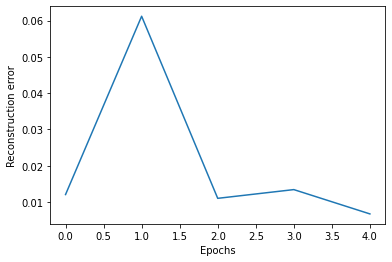

In [ ]:
fig = plt.figure()
plt.plot(loss_values)
plt.xlabel('Epochs')
plt.ylabel('Reconstruction error')
plt.show()

In [ ]:
learning_rate = 0.0001
autoencoder_p = Autoncoder()
autoencoder_p.to(device)
loss = nn.MSELoss()
optimizer = torch.optim.Adam(params=autoencoder_p.parameters(), lr=learning_rate, weight_decay=1e-5)
autoencoder_p.train()
loss_values = train(autoencoder_p, train_set, train_cleaned_set, 75, loss)


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:693: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch._C._nn.max_pool2d_with_indices(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch [1 / 75] average reconstruction error: 1.130235
Epoch [2 / 75] average reconstruction error: 0.996045
Epoch [3 / 75] average reconstruction error: 0.771707
Epoch [4 / 75] average reconstruction error: 0.310077
Epoch [5 / 75] average reconstruction error: 0.078194
Epoch [6 / 75] average reconstruction error: 0.070211
Epoch [7 / 75] average reconstruction error: 0.069852
Epoch [8 / 75] average reconstruction error: 0.069255
Epoch [9 / 75] average reconstruction error: 0.067564
Epoch [10 / 75] average reconstruction error: 0.069134
Epoch [11 / 75] average reconstruction error: 0.068172
Epoch [12 / 75] average reconstruction error: 0.068334
Epoch [13 / 75] average reconstruction error: 0.066915
Epoch [14 / 75] average reconstruction error: 0.066281
Epoch [15 / 75] average reconstruction error: 0.063809
Epoch [16 / 75] average reconstruction error: 0.059697
Epoch [17 / 75] average reconstruction error: 0.055440
Epoch [18 / 75] average reconstruction error: 0.052038
Epoch [19 / 75] ave

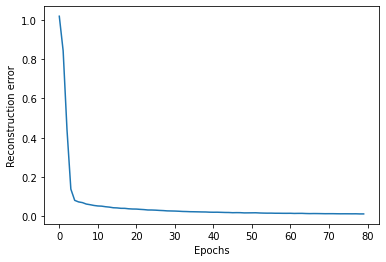

In [ ]:
fig = plt.figure()
plt.plot(loss_values)
plt.xlabel('Epochs')
plt.ylabel('Reconstruction error')
plt.show()

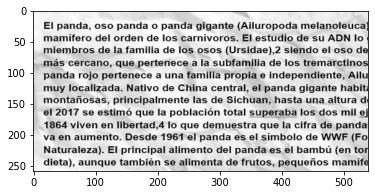

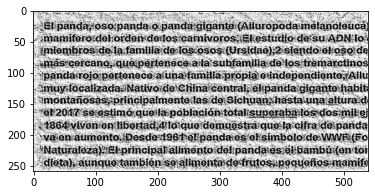

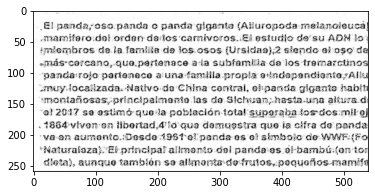

In [ ]:
autoencoder = autoencoder.to(device)
img = read_img('img_2.png')
img = img.to(device)

Show_Weight(img)
img_recon, indices1, indices2 = autoencoder.encoder(img)

img_recon = img_recon, indices1, indices2
img_recon= autoencoder.Decoder(img_recon)
Show_Weight(img_recon)

img_recon = autoencoder.Process(img_recon)
Show_Weight(img_recon)


Reducción de dimensionalidad:  torch.Size([98304])
Indices1:  torch.Size([1, 32, 129, 270])
Indices2:  torch.Size([1, 64, 64, 135])


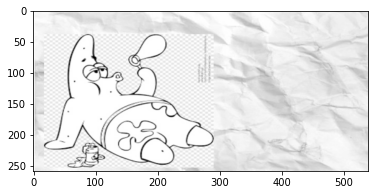

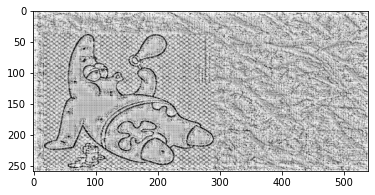

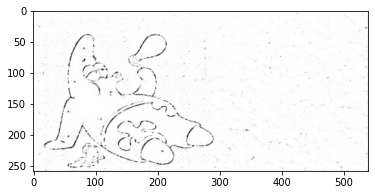

In [ ]:
def flatten(t):
    t = t.reshape(1, -1)
    t = t.squeeze()
    return t

autoencoder = autoencoder.to(device)
img = read_img('img_3.png')
img = img.to(device)

img_recon, indices1, indices2 = autoencoder.encoder(img)

img_recon = flatten(img_recon)
print('Reducción de dimensionalidad: ', img_recon.shape)
print('Indices1: ', indices1.shape)
print('Indices2: ', indices2.shape)
#img_recon = img_recon - torch.rand(98304).to(device)*10
#indices1 = torch.zeros(1, 32, 129, 270,dtype=torch.int64).to(device)
#indices2 = torch.zeros(1, 64, 64, 135,dtype=torch.int64).to(device)

#indices1 = indices1 + torch.rand(1, 32, 129, 270).to(device)*1.1
img_recon = img_recon.reshape(128, 64, 12).unsqueeze(dim = 0)
#img_recon = torch.zeros(1, 128, 64, 12).to(device)

indices1 = indices1.to(torch.int64)
indices2 = indices2.to(torch.int64)
img_recon = img_recon, indices1, indices2
img_recon= autoencoder.Decoder(img_recon)
Show_Weight(img)
Show_Weight(img_recon)

img_recon = autoencoder.Process(img_recon)
Show_Weight(img_recon)

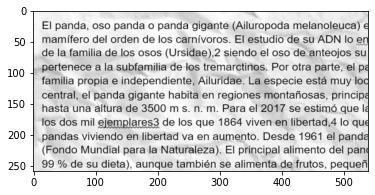

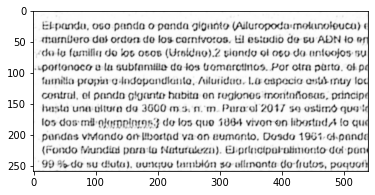

tensor([[[[0.7166, 0.9185, 0.9533,  ..., 0.9442, 0.9114, 0.7225],
          [0.8800, 0.9855, 0.9942,  ..., 0.9930, 0.9852, 0.9006],
          [0.9118, 0.9920, 0.9970,  ..., 0.9965, 0.9916, 0.9263],
          ...,
          [0.9184, 0.9920, 0.9960,  ..., 0.9861, 0.9763, 0.8757],
          [0.8649, 0.9793, 0.9865,  ..., 0.9679, 0.9471, 0.7961],
          [0.6017, 0.8442, 0.8669,  ..., 0.7984, 0.7470, 0.5319]]]],
       device='cuda:0', grad_fn=<TanhBackward>)

In [ ]:
img_autoencoder(autoencoder, 'img_1.png')

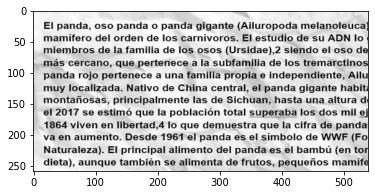

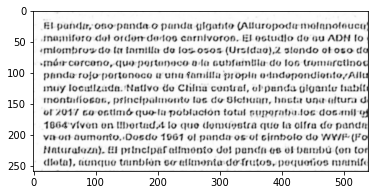

tensor([[[[0.7186, 0.9192, 0.9534,  ..., 0.9356, 0.8818, 0.6649],
          [0.8829, 0.9860, 0.9942,  ..., 0.9917, 0.9782, 0.8695],
          [0.9135, 0.9922, 0.9970,  ..., 0.9962, 0.9891, 0.9107],
          ...,
          [0.9213, 0.9906, 0.9930,  ..., 0.9946, 0.9844, 0.8783],
          [0.8689, 0.9780, 0.9828,  ..., 0.9810, 0.9570, 0.7936],
          [0.6085, 0.8438, 0.8618,  ..., 0.8361, 0.7624, 0.5236]]]],
       device='cuda:0', grad_fn=<TanhBackward>)

In [ ]:
img_autoencoder(autoencoder, 'img_2.png')

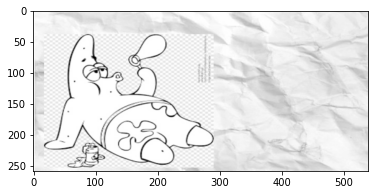

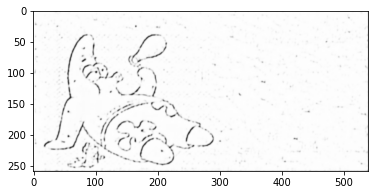

tensor([[[[0.7227, 0.9206, 0.9535,  ..., 0.9421, 0.9074, 0.7147],
          [0.8861, 0.9864, 0.9942,  ..., 0.9905, 0.9810, 0.8856],
          [0.9188, 0.9927, 0.9970,  ..., 0.9931, 0.9858, 0.9006],
          ...,
          [0.9173, 0.9849, 0.9782,  ..., 0.9924, 0.9812, 0.8762],
          [0.8714, 0.9728, 0.9667,  ..., 0.9718, 0.9459, 0.7820],
          [0.6192, 0.8396, 0.8318,  ..., 0.7896, 0.7258, 0.5051]]]],
       device='cuda:0', grad_fn=<TanhBackward>)

In [ ]:
img_autoencoder(autoencoder, 'img_3.png')